# Get brain tissue parcellation using kwyk model

In this notebook, we will use [kwyk](https://www.frontiersin.org/articles/10.3389/fninf.2019.00067/full) model to the get the 50 class brain parcellation. kwyk, is a bayesian model that is trained by freesurfer labels and gives an uncertainty map of predicted classes in addition to the output.

In the following cells, we will:

1. Get sample T1-weighted MR scans as an input image.
2. Load a pre-trained kwyk 50 class segmentation model.
3. Use nobrainer function to get the segmentation.

## Google Colaboratory

If you are using Colab, please switch your runtime to GPU. To do this, select `Runtime > Change runtime type` in the top menu. Then select GPU under `Hardware accelerator`. A GPU greatly speeds up training.




In this tutorial we will need to pull in external models using datalad. To support it we first install git-annex using Neurodebian.

**Note: Sometimes getting the gpg key can fail. If you notice such an error, simply re-execute the cell.**

In [ ]:
!wget -O- http://neuro.debian.net/lists/bionic.us-nh.full | tee /etc/apt/sources.list.d/neurodebian.sources.list \
 && export GNUPGHOME="$(mktemp -d)" \
 && echo "disable-ipv6" >> ${GNUPGHOME}/dirmngr.conf \
 && (apt-key adv --homedir $GNUPGHOME --recv-keys --keyserver hkp://pgpkeys.eu 0xA5D32F012649A5A9 \
|| { curl -sSL http://neuro.debian.net/_static/neuro.debian.net.asc | apt-key add -; } ) \
 && apt-get update \
 && apt-get install git-annex-standalone git

Let's make sure the correct version of git-annex is installed. This should be at least **8.20210223** or later.

In [ ]:
!git-annex version

In [ ]:
!pip install --no-cache-dir nilearn datalad datalad-osf
!pip install --no-cache-dir nobrainer

In [ ]:
import nobrainer
import tensorflow as tf
import nibabel as nib

# Get a sample T1w image 

We use the sample dataset available through nobrainer to get our prediction. 

In [ ]:
csv_of_filepaths = nobrainer.utils.get_data()
filepaths = nobrainer.io.read_csv(csv_of_filepaths)

train_paths = filepaths[:9]
evaluate_paths = filepaths[9:]

Here is an example of one of the images, with the freesurfer labels overlaid on the anatomical image.

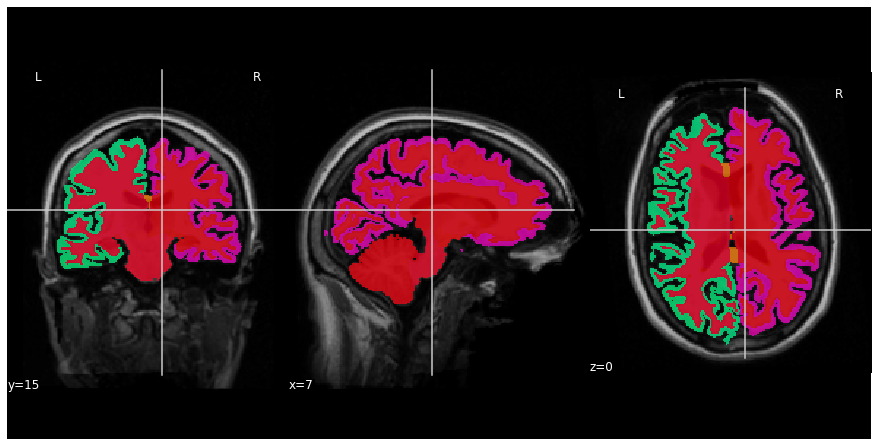

In [26]:
import matplotlib.pyplot as plt
from nilearn import plotting
fig = plt.figure(figsize=(12, 6))

plotting.plot_roi(train_paths[0][1], bg_img=train_paths[0][0], figure=fig, cmap=plt.cm.gist_rainbow)

**Note**: to use the kwyk models the input image dimension should be (256, 256, 256). if your image dimension is not as mentioned, use the `nibabel.processing.conform` function to conform it to the 256 block size. 

# Load pre-trained model

Use datalad to retrieve the kwyk trained models. there are 3 options to use:

1. Spike-and-slab dropout (bvwn_multi_prior)
2. MC Bernoulli dropout (bwn_multi)
3. MAP (bwn)

In [ ]:
! git config --global user.email "you@example.com" && git config --global user.name "Your Name"

In [ ]:
!datalad clone https://github.com/neuronets/trained-models && \
  cd trained-models && git-annex enableremote osf-storage && \
  datalad get -s osf-storage neuronets/kwyk/0.4.1/all_50_bvwn_multi_prior

Here we use the model with Spike-and-slab dropout

In [ ]:
model_path = "trained-models/neuronets/kwyk/0.4.1/all_50_bvwn_multi_prior/"

In [ ]:
batch_size = 2
volume_shape = (256, 256, 256)
block_shape = (32, 32, 32) # Do not change as this version of the model was trained on this block size

# Predict from the sample images

In [ ]:
from nobrainer.volume import standardize
from nobrainer.prediction import predict_by_estimator
import nibabel as nib

tf.compat.v1.enable_resource_variables()

image_path = evaluate_paths[0][0]
out,variance, entropy = predict_by_estimator(image_path, 
                                              model_path,
                                              block_shape = block_shape,
                                              batch_size = batch_size,
                                              normalizer = standardize,
                                              n_samples=2,
                                              return_variance=True,
                                              return_entropy=True,
                                              )
out.shape

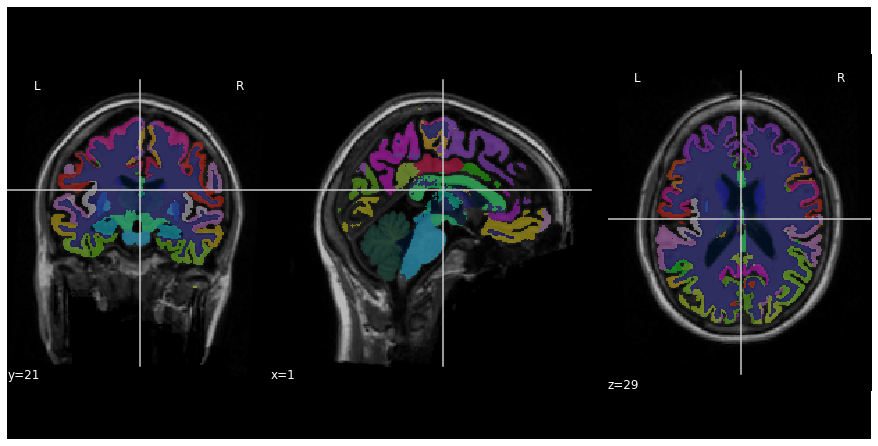

In [23]:
fig = plt.figure(figsize=(12, 6))
plotting.plot_roi(out, bg_img=image_path, alpha=0.4, figure=fig)

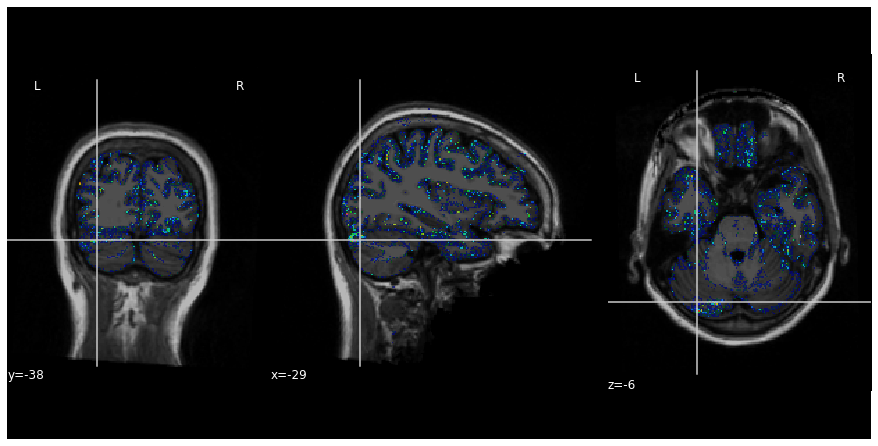

In [24]:
fig = plt.figure(figsize=(12, 6))
plotting.plot_roi(variance, bg_img=image_path, threshold=0.001, figure=fig)

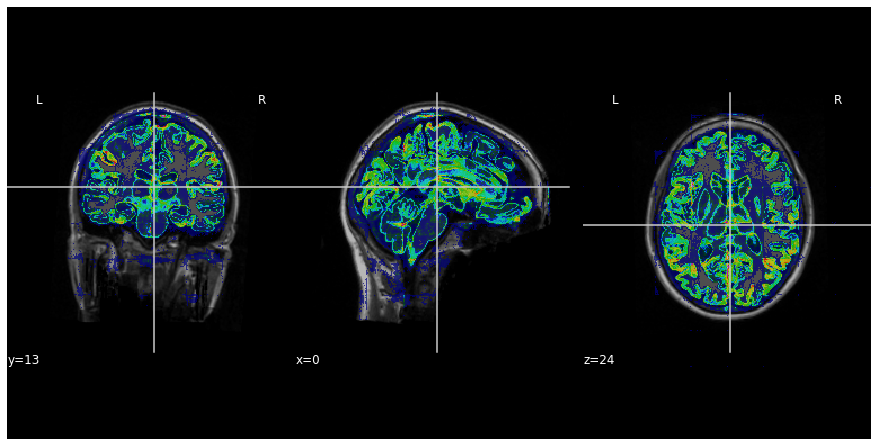

In [25]:
fig = plt.figure(figsize=(12, 6))
plotting.plot_roi(entropy, bg_img=image_path, threshold=0.001, figure=fig)